# S-parameter Exploration

Original author: David Banas <capn.freako@gmail.com>  
Original date:   June 11, 2020

Copyright &copy; 2020 David Banas; all rights reserved World wide.

This [Jupyter](http://jupyter.org) notebook was created in response to a [post](https://www.freelists.org/post/si-list/noncausal-ripples-in-impulse-response) to the [SI List](https://www.freelists.org/list/si-list) by [Tramp](mailto:farhilltramper@gmail.com), in which he inquired as to the correct method for converting the S-parameter data contained in [Touchstone](https://en.wikipedia.org/wiki/Touchstone_file) files into an _impulse response_.
It illustrates the correct method for doing this, as well as several commonly made mistakes, and can be used to explore this topic further.

## Problem Statement

Before writing any code, or slogging through any algebra, let's define what we want to do.
Our starting point is a *frequency domain* description of some channel, given to us in the form of a *Touchstone* file.
Now, Touchstone files contain several pieces of information about a channel.
The piece we're interested in is the *insertion loss*, which also goes by the name: *transfer function*, often denoted as: $H(f)$.

**Note:** $H(f)$ takes a *real* (and possibly negative) argument: $f$, and returns a *complex* value: $A e^{j \phi}$ ($A$ and $\phi$ real), which gives both the *magnitude* and *phase* of the channel response at a particular frequency, $f$.

**Note:** There's a degree of freedom in the Touchstone standard that creates an ambiguity in the notation used to refer to the insertion loss component of a Touchstone file.
We will assume that the insertion loss is contained in the $S[2,1]$ component of the Touchstone file.

Our problem statement is then:

<div align="center"><em>Convert the insertion loss component of the Touchstone file into the impulse response of the channel.</em></div>

But, how do we do that?
Well, we know that the insertion loss is another name for transfer function.
And we know that the transfer function and impulse response form a Fourier transform pair:

$$
h(t) <= \mathcal{F\{\}} => H(f)
$$

So, maybe it's as simple as: $h(t) = \text{ifft}(S[2,1])$?  
That'd be great, since just about every mathematical modeling package out there has an $\text{ifft}()$ function.

Let's try...

In [2]:
%matplotlib inline 
from matplotlib import pyplot as plt

import skrf as rf
import numpy as np
import scipy.signal as sig


## Channels

Load the channels of interest and sanity check them.

C:\Users\capnf\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\capnf\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\capnf\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\capnf\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes usi

Channel    Passive   
_____________________
   ch1        True   


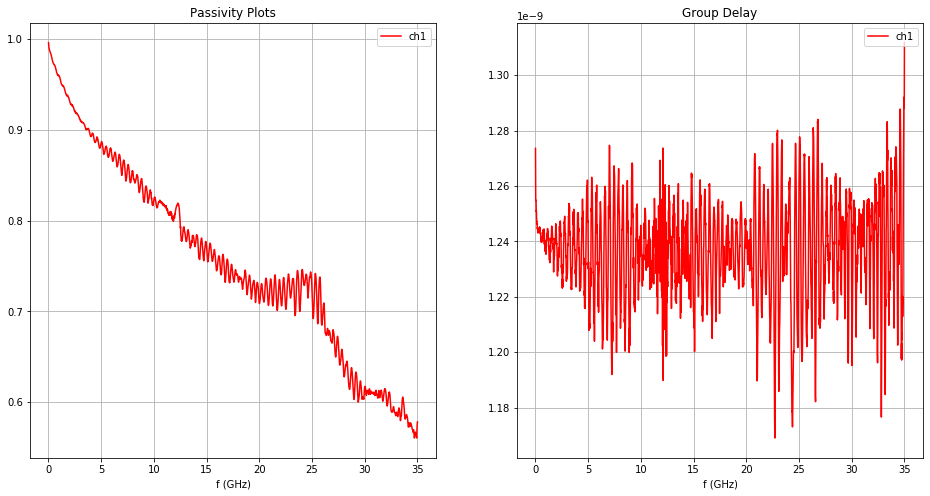

In [3]:
# Note: Change the following definition, as appropriate to your particular case.
tstone_file = '../Channels/deembedded_Diff_1_Assembly_1_Interposer_24.s4p'

# Note: Don't change anything below this line!

plt.figure(figsize=(16, 8))

def sdd_21(ntwk):
    """
    Given a 4-port single-ended network, return its differential throughput."

    Note that the following connectivity is assumed:
      - 1 ==> 2
      - 3 ==> 4
    """
    return 0.5*(ntwk.s21 - ntwk.s23 + ntwk.s43 - ntwk.s41)

# Load the channels of interest.
chnls = []
chnls.append(('ch1', rf.Network(tstone_file)))

# Create diagonal mask, for checking passivity, below.
n = chnls[0][1]
m = np.zeros(n.s[0].shape, dtype=bool)
np.fill_diagonal(m, True)

# Check them against several criteria.
passivities = []
clrs = ['r','g','b','c','m','y']
for (lbl, ntwk), clr in zip(chnls, clrs):
    passivity = np.array(list(map(lambda x: max(x[m]), ntwk.passivity)))
    if(max(passivity) <= 1.0):
        passivities.append(True)
    else:
        passivities.append(False)
    plt.subplot(121)
    plt.plot(ntwk.f / 1e9, passivity, clr, label=lbl)

    plt.subplot(122)
    plt.plot(ntwk.f / 1e9, sdd_21(ntwk).group_delay.flatten(), clr, label=lbl)

#Plot passivities.
plt.subplot(121)
plt.title("Passivity Plots")
plt.xlabel("f (GHz)")
plt.grid()
plt.legend(loc='upper right')

#Plot group delays.
plt.subplot(122)
plt.title("Group Delay")
plt.xlabel("f (GHz)")
plt.grid()
plt.legend(loc='upper right')

# Print a summary of the results.
print("{:10s} {:10s}".format('Channel','Passive'))
print('_'*21)
for ((lbl, ntwk), passive) in zip(chnls, passivities):
    print("{:^10s} {:^10s}".format(lbl, str(passive)))


Channel is passive, but has some serious noise in its group delay.

## Differential Insertion Loss

Convert to mixed mode and display Sdd[2,1].

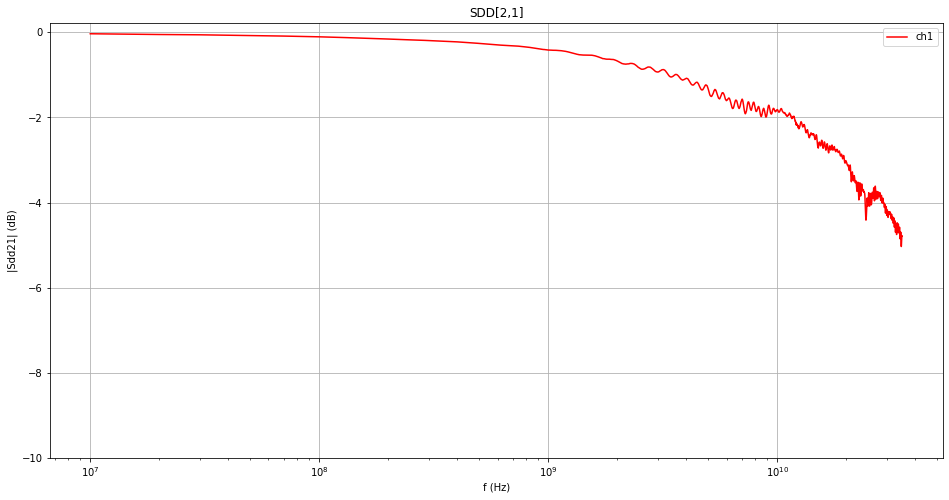

In [4]:
# Plot their differential insertion losses.
sdd_21s = []
plt.figure(figsize=(16, 8))
for (lbl, ntwk), clr in zip(chnls, clrs):
    H = sdd_21(ntwk)
    sdd_21s.append(H)
    plt.semilogx(ntwk.f, 20 * np.log10(abs(H.s[:,0,0])), clr, label=lbl)
plt.title("SDD[2,1]")
plt.xlabel("f (Hz)")
plt.ylabel("|Sdd21| (dB)")
plt.grid()
plt.legend(loc='upper right')
plt.axis(ymin=-10)
plt.show()

Okay, looks reasonable.

## Impulse Responses

Next, we'll see how to convert the *insertion loss* data in the Touchstone file into an *impulse response*.
We'll do it naively, first, as per the discussion above, and then show how to do it correctly.

### Naively

ch1 ref. frequencies: 0.0-35.0 GHz, 3501 pts
ch1 frequencies: 0.01-35.0 GHz, 3500 pts


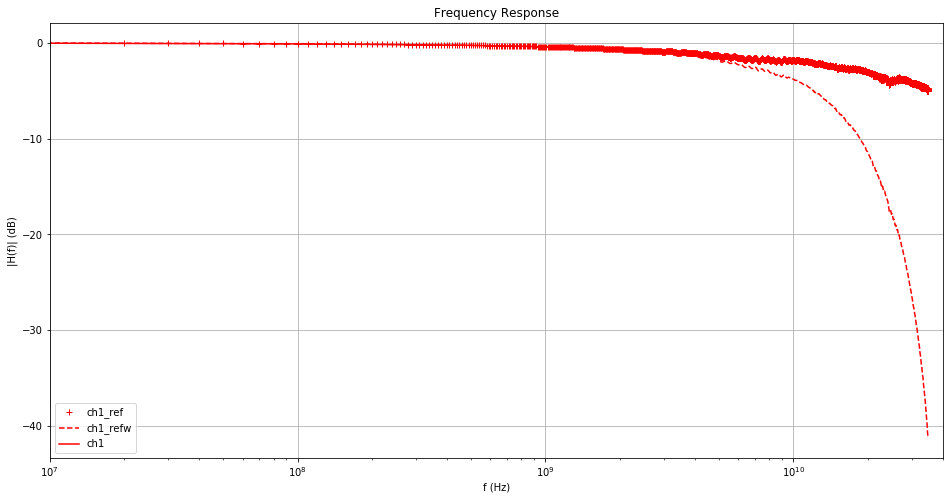

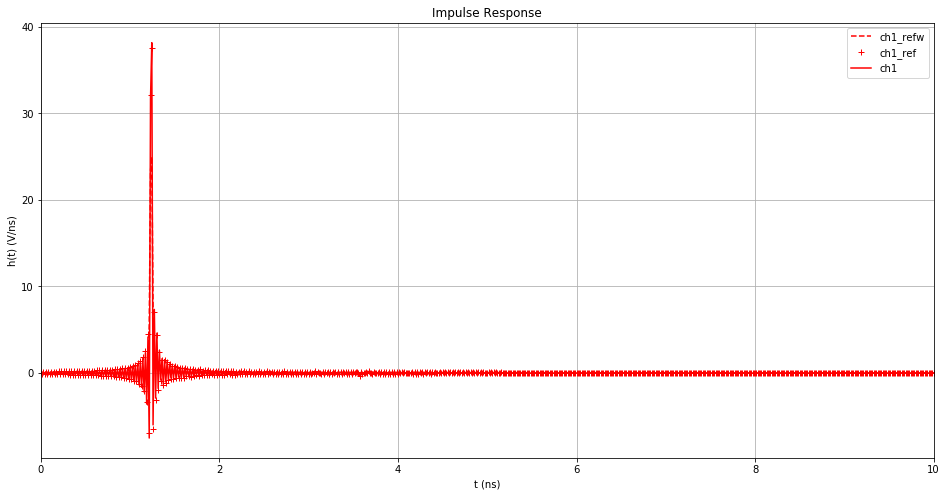

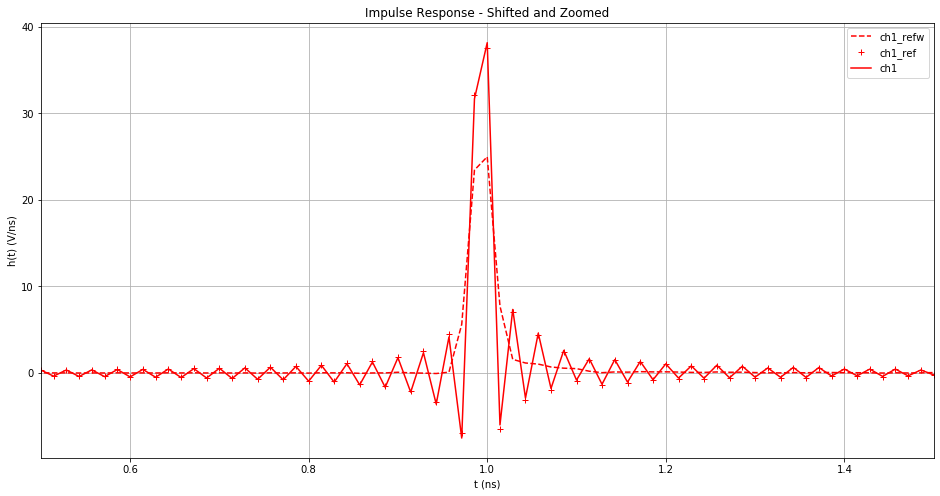

In [19]:
# Here, I calculate the impulse response myself,
# as opposed to using the 'Network.s_time()' function provided by skrf,
# because I've found I get better results, and I'm trying to illustrate the technique for Tramp.

ts = []
fs = []
hs = []
ss = []
trefs = []
frefs = []
hrefs = []
srefs = []

for (lbl, _), sdd_21, clr in zip(chnls, sdd_21s, clrs):
    Href   = sdd_21_ref.s[:,0,0]
    # Generate reference, using scikit-rf, both windowed and not.
    sdd_21_refw = sdd_21.extrapolate_to_dc().windowed()
    sdd_21_ref  = sdd_21.extrapolate_to_dc()
    Href   = sdd_21_ref.s[:,0,0]
    Href  /= abs(Href[0])
    Hrefw  = sdd_21_refw.s[:,0,0]
    Hrefw /= abs(Hrefw[0])
    fref   = sdd_21_ref.f
    Fref   = rf.Frequency.from_f(fref / 1e9)  ## skrf.Frequency.from_f() expects its argument to be in units of GHz.
    print("{} ref. frequencies: {}".format(lbl, Fref))
    href   = np.fft.irfft(Href)
    href  /= np.abs(href.sum())  # Equivalent to assuming that step response settles at 1.
    hrefw  = np.fft.irfft(Hrefw)
    hrefw /= np.abs(hrefw.sum())  # Equivalent to assuming that step response settles at 1.

    # Generate manually constructed frequency domain data vector.
    # Form frequency vector.
    f = sdd_21.f
    fmin = f[0]
    if(fmin == 0):  # Correct, if d.c. point was included in original data.
        fmin = f[1]
    fmax = f[-1]
    f = np.arange(fmin, fmax + fmin, fmin)
    F = rf.Frequency.from_f(f / 1e9)  ## skrf.Frequency.from_f() expects its argument to be in units of GHz.
    print("{} frequencies: {}".format(lbl, F))

    # Form impulse response from frequency response.
    sdd_21 = sdd_21.interpolate_from_f(F)
    H = sdd_21.s[:,0,0]
    H = np.concatenate((H, np.conj(np.flip(H[:-1], 0))))  # Forming the vector that fft() would've outputted.
    h = np.real(np.fft.ifft(H))
#     Hp = H.copy()
#     Hp = np.pad(Hp, (1,0), 'constant', constant_values=1.0)  # Presume d.c. value = 1.
#     h = np.fft.irfft(Hp)
    h /= np.abs(h.sum())  # Equivalent to assuming that step response settles at 1.
    H = H[: len(F)]
    
    # Form step response from impulse response.
    s = np.cumsum(h)
    sref = np.cumsum(href)
    
    # Form time vector.
    t0 = 1. / (2. * fmax)  # Sampling interval = 1 / (2 fNyquist).
    t = np.array([n * t0 for n in range(len(h))])
    tref = np.array([n * t0 for n in range(len(href))])

    # Save results.
    ts.append(t)
    fs.append(f)
    hs.append(h)
    ss.append(s)
    trefs.append(tref)
    frefs.append(fref)
    hrefs.append(href)
    srefs.append(sref)

    # Plot results.
    def shift_peak(t, x, new_peak_loc=1e-9):
        t_peak = t[np.argmax(x)]
        delta_t = new_peak_loc - t_peak
        return np.roll(x, int(delta_t / t[1]))
        
    plt.figure(1, figsize=(16, 8))
    plt.semilogx(fref, 20. * np.log10(np.abs(Href)), clr+'+', label=lbl+'_ref')
    plt.semilogx(fref, 20. * np.log10(np.abs(Hrefw)), clr+'--', label=lbl+'_refw')
    plt.semilogx(f,    20. * np.log10(np.abs(H)),    clr,      label=lbl)

    plt.figure(2, figsize=(16, 8))
    plt.plot(tref * 1e9, hrefw / t0 * 1e-9, clr+'--', label=lbl+'_refw')
    plt.plot(tref * 1e9, href / t0 * 1e-9, clr+'+', label=lbl+'_ref')
    plt.plot(t * 1e9,    h / t0 * 1e-9,    clr,      label=lbl)

    plt.figure(3, figsize=(16, 8))
    plt.plot(tref * 1e9, shift_peak(tref, hrefw) / t0 * 1e-9, clr+'--', label=lbl+'_refw')
    plt.plot(tref * 1e9, shift_peak(tref, href) / t0 * 1e-9, clr+'+', label=lbl+'_ref')
    plt.plot(t * 1e9,    shift_peak(t, h)       / t0 * 1e-9, clr,      label=lbl)

# Annotate the plots.
plt.figure(1, figsize=(16, 8))
plt.title("Frequency Response")
plt.xlabel("f (Hz)")
plt.ylabel("|H(f)| (dB)")
plt.grid()
plt.legend(loc='lower left')
plt.axis(xmin=1e7, xmax=40e9);

plt.figure(2, figsize=(16, 8))
plt.title("Impulse Response")
plt.xlabel("t (ns)")
plt.ylabel("h(t) (V/ns)")
plt.grid()
plt.legend(loc='upper right')
plt.axis(xmin=0, xmax=10);

plt.figure(3, figsize=(16, 8))
plt.title("Impulse Response - Shifted and Zoomed")
plt.xlabel("t (ns)")
plt.ylabel("h(t) (V/ns)")
plt.grid()
plt.legend(loc='upper right')
plt.axis(xmin=0.5, xmax=1.5);


### Correctly

ch1 ref. frequencies: 0.0-35.0 GHz, 3501 pts
ch1 frequencies: 0.01-35.0 GHz, 3500 pts


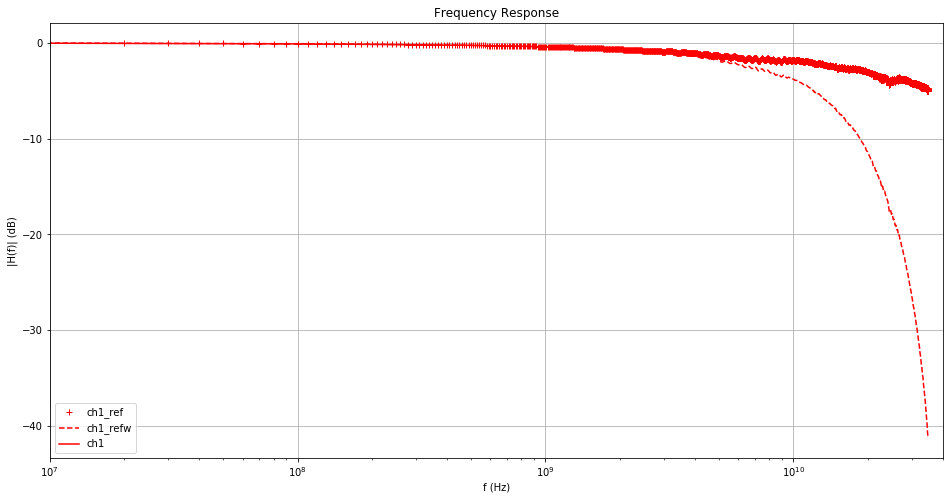

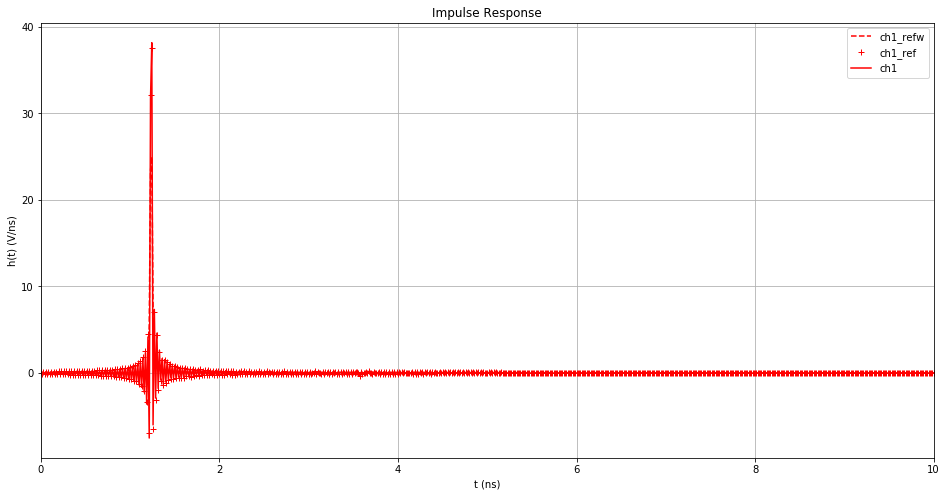

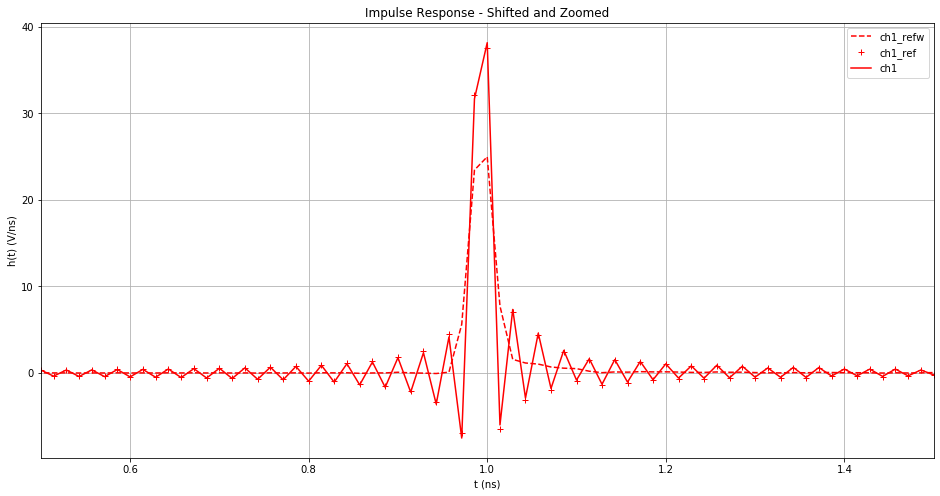

In [19]:
# Here, I calculate the impulse response myself,
# as opposed to using the 'Network.s_time()' function provided by skrf,
# because I've found I get better results, and I'm trying to illustrate the technique for Tramp.

ts = []
fs = []
hs = []
ss = []
trefs = []
frefs = []
hrefs = []
srefs = []

for (lbl, _), sdd_21, clr in zip(chnls, sdd_21s, clrs):
    # Generate reference, using scikit-rf, both windowed and not.
    sdd_21_refw = sdd_21.extrapolate_to_dc().windowed()
    sdd_21_ref  = sdd_21.extrapolate_to_dc()
    Href   = sdd_21_ref.s[:,0,0]
    Href  /= abs(Href[0])
    Hrefw  = sdd_21_refw.s[:,0,0]
    Hrefw /= abs(Hrefw[0])
    fref   = sdd_21_ref.f
    Fref   = rf.Frequency.from_f(fref / 1e9)  ## skrf.Frequency.from_f() expects its argument to be in units of GHz.
    print("{} ref. frequencies: {}".format(lbl, Fref))
    href   = np.fft.irfft(Href)
    href  /= np.abs(href.sum())  # Equivalent to assuming that step response settles at 1.
    hrefw  = np.fft.irfft(Hrefw)
    hrefw /= np.abs(hrefw.sum())  # Equivalent to assuming that step response settles at 1.

    # Generate manually constructed frequency domain data vector.
    # Form frequency vector.
    f = sdd_21.f
    fmin = f[0]
    if(fmin == 0):  # Correct, if d.c. point was included in original data.
        fmin = f[1]
    fmax = f[-1]
    f = np.arange(fmin, fmax + fmin, fmin)
    F = rf.Frequency.from_f(f / 1e9)  ## skrf.Frequency.from_f() expects its argument to be in units of GHz.
    print("{} frequencies: {}".format(lbl, F))

    # Form impulse response from frequency response.
    sdd_21 = sdd_21.interpolate_from_f(F)
    H = sdd_21.s[:,0,0]
    H = np.concatenate((H, np.conj(np.flip(H[:-1], 0))))  # Forming the vector that fft() would've outputted.
    h = np.real(np.fft.ifft(H))
#     Hp = H.copy()
#     Hp = np.pad(Hp, (1,0), 'constant', constant_values=1.0)  # Presume d.c. value = 1.
#     h = np.fft.irfft(Hp)
    h /= np.abs(h.sum())  # Equivalent to assuming that step response settles at 1.
    H = H[: len(F)]
    
    # Form step response from impulse response.
    s = np.cumsum(h)
    sref = np.cumsum(href)
    
    # Form time vector.
    t0 = 1. / (2. * fmax)  # Sampling interval = 1 / (2 fNyquist).
    t = np.array([n * t0 for n in range(len(h))])
    tref = np.array([n * t0 for n in range(len(href))])

    # Save results.
    ts.append(t)
    fs.append(f)
    hs.append(h)
    ss.append(s)
    trefs.append(tref)
    frefs.append(fref)
    hrefs.append(href)
    srefs.append(sref)

    # Plot results.
    def shift_peak(t, x, new_peak_loc=1e-9):
        t_peak = t[np.argmax(x)]
        delta_t = new_peak_loc - t_peak
        return np.roll(x, int(delta_t / t[1]))
        
    plt.figure(1, figsize=(16, 8))
    plt.semilogx(fref, 20. * np.log10(np.abs(Href)), clr+'+', label=lbl+'_ref')
    plt.semilogx(fref, 20. * np.log10(np.abs(Hrefw)), clr+'--', label=lbl+'_refw')
    plt.semilogx(f,    20. * np.log10(np.abs(H)),    clr,      label=lbl)

    plt.figure(2, figsize=(16, 8))
    plt.plot(tref * 1e9, hrefw / t0 * 1e-9, clr+'--', label=lbl+'_refw')
    plt.plot(tref * 1e9, href / t0 * 1e-9, clr+'+', label=lbl+'_ref')
    plt.plot(t * 1e9,    h / t0 * 1e-9,    clr,      label=lbl)

    plt.figure(3, figsize=(16, 8))
    plt.plot(tref * 1e9, shift_peak(tref, hrefw) / t0 * 1e-9, clr+'--', label=lbl+'_refw')
    plt.plot(tref * 1e9, shift_peak(tref, href) / t0 * 1e-9, clr+'+', label=lbl+'_ref')
    plt.plot(t * 1e9,    shift_peak(t, h)       / t0 * 1e-9, clr,      label=lbl)

# Annotate the plots.
plt.figure(1, figsize=(16, 8))
plt.title("Frequency Response")
plt.xlabel("f (Hz)")
plt.ylabel("|H(f)| (dB)")
plt.grid()
plt.legend(loc='lower left')
plt.axis(xmin=1e7, xmax=40e9);

plt.figure(2, figsize=(16, 8))
plt.title("Impulse Response")
plt.xlabel("t (ns)")
plt.ylabel("h(t) (V/ns)")
plt.grid()
plt.legend(loc='upper right')
plt.axis(xmin=0, xmax=10);

plt.figure(3, figsize=(16, 8))
plt.title("Impulse Response - Shifted and Zoomed")
plt.xlabel("t (ns)")
plt.ylabel("h(t) (V/ns)")
plt.grid()
plt.legend(loc='upper right')
plt.axis(xmin=0.5, xmax=1.5);


Note the following in the plots above:

1. The frequency response of the *windowed* reference ("ch1_refw", dashed line) drops off sharply at the right end of the plot, due to the applied windowing.

1. The impulse response of the windowed reference lacks the non-causal rippling present in both the non-windowed reference and the transformed manually constructed frequency domain vector.

1. The non-windowed reference and manually constructed vector match exactly in both the frequency and time domains, indicating that we constructed our frequency domain vector correctly.

## Step Responses

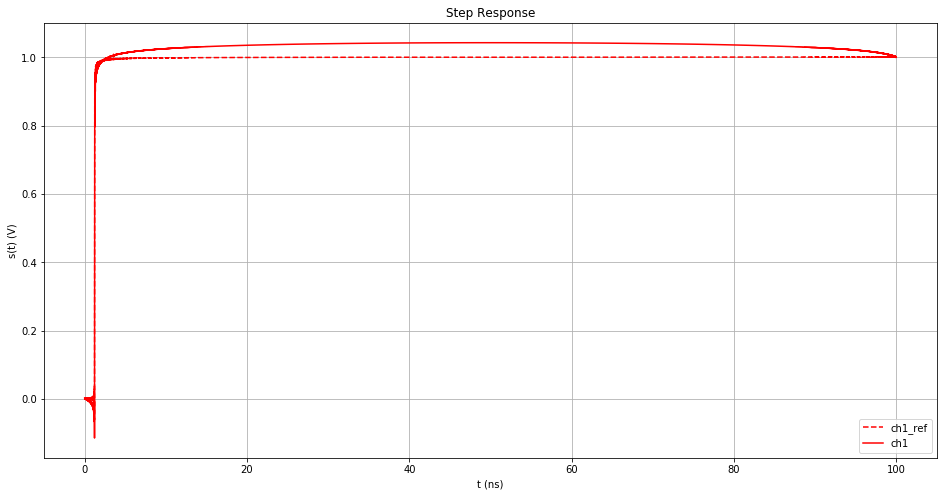

In [20]:
plt.figure(figsize=(16, 8))
for (lbl, _), t, s, tref, sref, clr in zip(chnls, ts, ss, trefs, srefs, clrs):
    plt.plot(tref * 1e9, sref, clr+'--', label=lbl+'_ref')
    plt.plot(t    * 1e9, s,    clr,      label=lbl)
plt.title("Step Response")
plt.xlabel("t (ns)")
plt.ylabel("s(t) (V)")
plt.grid()
plt.legend(loc='lower right');
# plt.axis(xmin=1.8, xmax=2.0)

This doesn't look right.

In [21]:
# Save the step responses.
for (lbl, _), t, s in zip(chnls, trefs, srefs):
    with open(lbl+'_s.csv', 'wt') as file:
        for x, y in zip(t, s):
            # print >> file, "{:014.12f}, {:05.3f}".format(x, y)
            print("{:014.12f}, {:05.3f}".format(x, y), file=file)

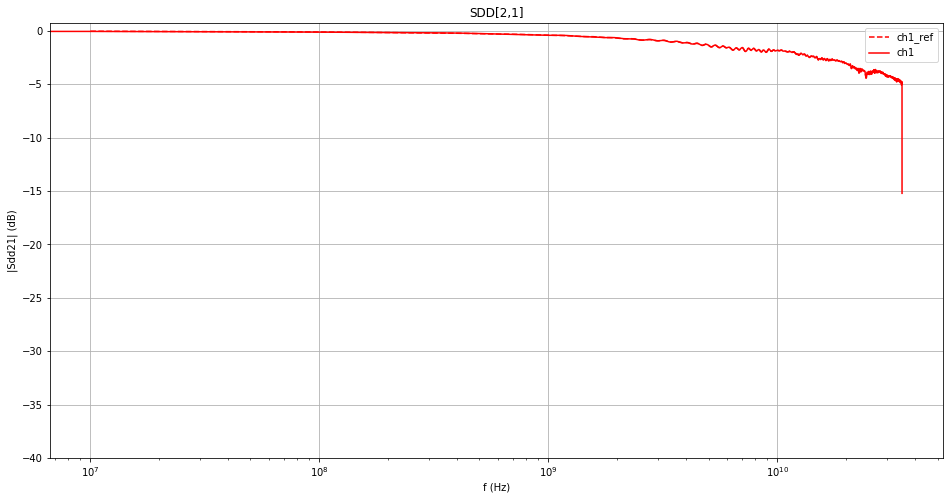

In [22]:
# Take them back into the frequency domain and compare to original data.
hps = []
plt.figure(figsize=(16, 8))
for f, s, (lbl, _), Href, clr in zip(frefs, srefs, chnls, sdd_21s, clrs):
    h = np.diff(s)
    h = np.pad(h, (1, 0), 'constant', constant_values=0)
    H = np.fft.fft(h)
    # Using [1], as opposed to [0], to accomodate ch1. (See, below.)
    # I'm assuming the strange behavior in ch1 is due to me forcing d.c. values of 1.
    H *= abs(Href.s[:,0,0][1]) / abs(H[1])  # Normalize the "d.c." levels.
    plt.semilogx(Href.f, 20 * np.log10(abs(Href.s[:,0,0])), clr+'--', label=lbl+'_ref')
    plt.semilogx(f,      20 * np.log10(abs(H[:len(f)])),    clr,      label=lbl)

plt.title("SDD[2,1]")
plt.xlabel("f (Hz)")
plt.ylabel("|Sdd21| (dB)")
plt.grid()
plt.legend(loc='upper right')
plt.axis(ymin=-40);


This Touchstone file has serious problems!